## NYC Taxi dataset analysis

This notenook should be run from the Jupypter Server deployed on the AzureML Cluster

First get the run object for the cluster we are running on (this will fail if not run on the cluster):

In [9]:
from azureml.core import Run
run = Run.get_context()
run.get_metrics()

{'headnode': '172.17.0.7',
 'scheduler': '172.17.0.7:8786',
 'dashboard': '172.17.0.7:8787',
 'data': '/mnt/batch/tasks/shared/LS_root/jobs/vnettest/azureml/init-dask-jupyter_1569837452_781f9040/mounts/workspaceblobstore',
 'jupyter-server': ['http://172.17.0.7:8888/?token=328966d31212f8eebaea6b4df97c2bfbbc9819d2dc7049c2',
  'http://172.17.0.7:8889/?token=a8c3ecc047365ec1b65bf7d6dce1ef44c1161f7b2f3a3c1c',
  'http://172.17.0.7:8890/?token=2c572c6a478a93402e22baae68e31618d7fa839097740e79']}

Fetch the list of data files from the mounted share:

In [10]:
import os
filenames = os.listdir(run.get_metrics()['data'] + '/nyctaxi')
filenames

['yellow_tripdata_2015-10.csv',
 'yellow_tripdata_2015-04.csv',
 'yellow_tripdata_2015-03.csv',
 'yellow_tripdata_2015-08.csv',
 'yellow_tripdata_2015-07.csv',
 'yellow_tripdata_2015-09.csv',
 'yellow_tripdata_2015-01.csv',
 'yellow_tripdata_2015-02.csv',
 'yellow_tripdata_2015-05.csv',
 'yellow_tripdata_2015-06.csv',
 'yellow_tripdata_2015-11.csv',
 'yellow_tripdata_2015-12.csv']

### Get the cluster client
Since this jupyter server is running on the scheduler node of the cluster, we just need to connect to localhost.

In [11]:
import distributed
client = distributed.Client('tcp://localhost:8786')
client

Client Scheduler: tcp://172.17.0.7:8786 Dashboard: http://172.17.0.7:8787/status,Cluster Workers: 6 Cores: 6 Memory: 0 B


In [12]:
import dask

print("- setting dask settings")
dask.config.set({'distributed.scheduler.work-stealing': False})
dask.config.set({'distributed.scheduler.bandwidth': 1})

print("-- Changes to dask settings")
print("--- Setting work-stealing to ", dask.config.get('distributed.scheduler.work-stealing'))
print("--- Setting scheduler bandwidth to ", dask.config.get('distributed.scheduler.bandwidth'))
print("-- Settings updates complete")

- setting dask settings
-- Changes to dask settings
--- Setting work-stealing to  False
--- Setting scheduler bandwidth to  1
-- Settings updates complete


In [42]:
# helper function which takes a DataFrame partition
def clean(df_part, remap, must_haves):    
    # some col-names include pre-pended spaces remove & lowercase column names
    tmp = {col:col.strip().lower() for col in list(df_part.columns)}
    df_part = df_part.rename(tmp)
    
    # rename using the supplied mapping
    df_part = df_part.rename(remap)
    
    # iterate through columns in this df partition
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            df_part = df_part.drop(col)
            continue

        if df_part[col].dtype == 'object' and col in ['pickup_datetime', 'dropoff_datetime']:
            df_part[col] = df_part[col].astype('datetime64[ms]')
            continue
            
        # if column was read as a string, recast as float
        if df_part[col].dtype == 'object':
            df_part[col] = df_part[col].str.fillna('-1')
            df_part[col] = df_part[col].astype('float32')
        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
            if 'int' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('int32')
            if 'float' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('float32')
            df_part[col] = df_part[col].fillna(-1)

    return df_part

In [43]:
import os
import cudf

def read_csv(path):
    import cudf
    # list of column names that need to be re-mapped
    remap = {}
    remap['tpep_pickup_datetime'] = 'pickup_datetime'
    remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
    remap['ratecodeid'] = 'rate_code'

    #create a list of columns & dtypes the df must have
    must_haves = {
     'pickup_datetime': 'datetime64[ms]',
     'dropoff_datetime': 'datetime64[ms]',
     'passenger_count': 'int32',
     'trip_distance': 'float32',
     'pickup_longitude': 'float32',
     'pickup_latitude': 'float32',
     'rate_code': 'int32',
     'dropoff_longitude': 'float32',
     'dropoff_latitude': 'float32',
     'fare_amount': 'float32'
    }
    
    df = cudf.read_csv(path)
    return clean(df, remap, must_haves)

paths = [os.path.join(run.get_metrics()["data"], "nyctaxi/") + filename for filename in filenames]
data_paths = client.scatter(paths)
dfs = [client.submit(read_csv, data_path) for data_path in data_paths]

In [44]:
import dask_cudf

taxi_df = dask_cudf.from_delayed(dfs)

In [45]:
taxi_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2015-10-01 00:00:00,2015-10-01 00:05:48,1,1.10,-73.935516,40.761238,1,-73.944351,40.754578,6.00
1,2015-10-01 00:00:00,2015-10-01 00:00:00,1,7.68,-73.989937,40.743439,1,-73.986687,40.689129,27.50
2,2015-10-01 00:00:00,2015-10-01 00:00:00,2,2.53,-73.987328,40.720020,1,-73.999084,40.744381,12.50
3,2015-10-01 00:00:00,2015-10-01 00:00:00,0,1.20,-73.953758,40.743385,5,-73.930008,40.736622,25.26
4,2015-10-01 00:00:01,2015-10-01 00:16:19,1,3.80,-73.984016,40.755222,1,-73.959869,40.801323,15.50


In [48]:
import numpy as np
import numba, xgboost, socket
import dask, dask_cudf
from dask.distributed import Client, wait

In [49]:
taxi_df.columns

Index(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
       'dropoff_longitude', 'dropoff_latitude', 'fare_amount'],
      dtype='object')

In [50]:
# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42'
]
taxi_df = taxi_df.query(' and '.join(query_frags))

# inspect the results of cleaning
taxi_df.head().to_pandas()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2015-10-01 00:00:00,2015-10-01 00:05:48,1,1.10,-73.935516,40.761238,1,-73.944351,40.754578,6.0
1,2015-10-01 00:00:00,2015-10-01 00:00:00,1,7.68,-73.989937,40.743439,1,-73.986687,40.689129,27.5
2,2015-10-01 00:00:00,2015-10-01 00:00:00,2,2.53,-73.987328,40.720020,1,-73.999084,40.744381,12.5
4,2015-10-01 00:00:01,2015-10-01 00:16:19,1,3.80,-73.984016,40.755222,1,-73.959869,40.801323,15.5
5,2015-10-01 00:00:01,2015-10-01 00:13:41,1,3.10,-73.975296,40.751396,1,-73.970924,40.785984,12.5


In [51]:
import math
from math import cos, sin, asin, sqrt, pi
import numpy as np

def haversine_distance_kernel(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi/180 * x_1
        y_1 = pi/180 * y_1
        x_2 = pi/180 * x_2
        y_2 = pi/180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat/2)**2 + cos(x_1) * cos(x_2) * sin(dlon/2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Radius of earth in kilometers
        
        h_distance[i] = c * r

def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] <3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m*2.6) + y + (y//4) + (c//4) -2*c)%7
        
def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['diff'] = df['dropoff_datetime'].astype('int32') - df['pickup_datetime'].astype('int32')
    
    df['pickup_latitude_r'] = df['pickup_latitude']//.01*.01
    df['pickup_longitude_r'] = df['pickup_longitude']//.01*.01
    df['dropoff_latitude_r'] = df['dropoff_latitude']//.01*.01
    df['dropoff_longitude_r'] = df['dropoff_longitude']//.01*.01
    
    df = df.drop('pickup_datetime')
    df = df.drop('dropoff_datetime')
    
    
    df = df.apply_rows(haversine_distance_kernel,
                   incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
                   outcols=dict(h_distance=np.float32),
                   kwargs=dict())
    
    
    df = df.apply_rows(day_of_the_week_kernel,
                      incols=['day', 'month', 'year'],
                      outcols=dict(day_of_week=np.float32),
                      kwargs=dict())
    
    
    df['is_weekend'] = (df['day_of_week']<2)
    return df

In [52]:
# actually add the features
taxi_df = taxi_df.map_partitions(add_features).persist()
# inspect the result
taxi_df.head().to_pandas()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,diff,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,h_distance,day_of_week,is_weekend
0,1,1.10,-73.935516,40.761238,1,-73.944351,40.754578,6.0,0,2015,10,1,348000,40.759998,-73.939995,40.750000,-73.949997,1.049876,5.0,False
1,1,7.68,-73.989937,40.743439,1,-73.986687,40.689129,27.5,0,2015,10,1,0,40.739998,-73.989998,40.680000,-73.989998,6.045188,5.0,False
2,2,2.53,-73.987328,40.720020,1,-73.999084,40.744381,12.5,0,2015,10,1,0,40.719997,-73.989998,40.739998,-74.000000,2.884243,5.0,False
4,1,3.80,-73.984016,40.755222,1,-73.959869,40.801323,15.5,0,2015,10,1,978000,40.750000,-73.989998,40.799999,-73.959999,5.514657,5.0,False
5,1,3.10,-73.975296,40.751396,1,-73.970924,40.785984,12.5,0,2015,10,1,820000,40.750000,-73.979996,40.779999,-73.979996,3.863575,5.0,False


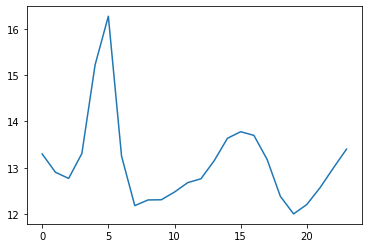

In [53]:
%matplotlib inline
taxi_df.groupby('hour').fare_amount.mean().compute().to_pandas().sort_index().plot();

In [54]:
%%time
X_train = taxi_df.query('day < 25').persist()

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']].persist()
# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# this wont return until all data is in GPU memory
done = wait([X_train, Y_train])

CPU times: user 381 ms, sys: 21.9 ms, total: 403 ms
Wall time: 5.34 s


## Notes on training with XGBoost with Azure

* Because Dask-XGBoost parses the `client` for the raw IP address, it passes `"localhost"` to RABIT if the `client` was configured to use `"localhost"` with SSH forwarding. This means Dask-XGBoost, as it exists, does not support Azure with this method.
* There are several bugs and issues with the Dask submodule of XGBoost:
    1. Data co-locality is not enforced (labels and data may not be on the same worker)
    2. Data locality is not enforced (a data partition, x, may not be assigned to the worker, n, upon which it resides originally ... so, data may need to be shuffled

The latter (Dask submodule of XGBoost) is being fixed in this PR: https://github.com/dmlc/xgboost/pull/4819

This means the code below (Dask submodule of XGBoost) will not work, and replacing the call with Dask-XGBoost will not work.

In [55]:
params = {
  'num_rounds':   100,
  'max_depth':    8,
  'max_leaves':   2**8,
  'tree_method':  'gpu_hist',
  'objective':    'reg:squarederror',
  'grow_policy':  'lossguide'
}

bst = dask_xgboost.train(client, params, X_train, Y_train, num_boost_round=params['num_rounds'])

NameError: name 'dask_xgboost' is not defined

In [16]:
run.cancel()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/data/anaconda/envs/rapids-0.9/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/data/anaconda/envs/rapids-0.9/lib/python3.7/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/data/anaconda/envs/rapids-0.9/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/data/anaconda/envs/rapids-0.9/lib/python3.7/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/data/anaconda/envs/rapids-0.9/lib/python3.7/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(co

In [8]:
run = Experiment(ws, "init-dask-jupyter").get_runs().__next__()

In [18]:
run.cancel()

In [17]:
run.get_metrics()

{'headnode': '172.17.0.6',
 'scheduler': '172.17.0.6:8786',
 'dashboard': '172.17.0.6:8787',
 'data': '/mnt/batch/tasks/shared/LS_root/jobs/vnettest/azureml/init-dask-jupyter_1569822164_fb7a80b9/mounts/workspaceblobstore',
 'jupyter-server': 'http://0.0.0.0:8888/'}